In [163]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

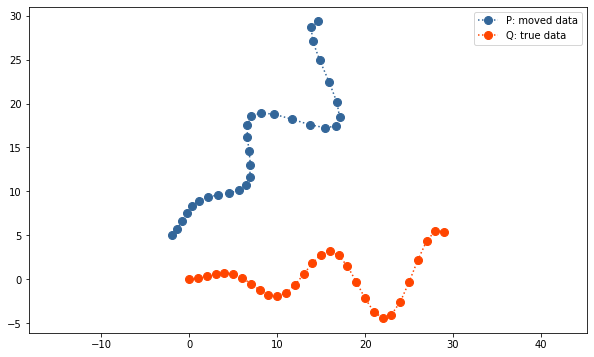

In [164]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

#initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

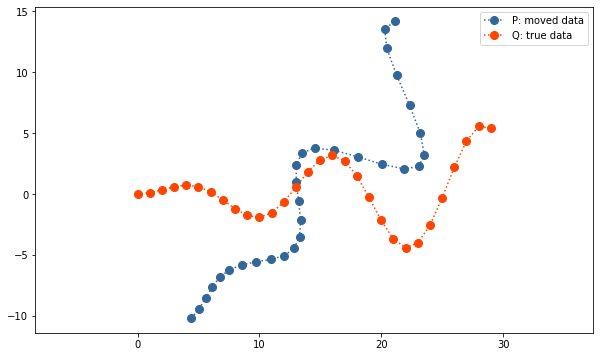

In [165]:

def center_data(moved_data, true_data):
  true_center = np.array([sum(true_data[0])/len(true_data[0]),sum(true_data[1])/len(true_data[1])])
  moved_center = np.array([sum(moved_data[0])/len(moved_data[0]),sum(moved_data[1])/len(moved_data[1])])
  center_diff = moved_center - true_center
  centered_data = np.array([moved_data[0]-center_diff[0],moved_data[1]-center_diff[1]])
  return centered_data

plot_data(center_data(moved_data, true_data), true_data, "P: moved data", "Q: true data")
plt.show()

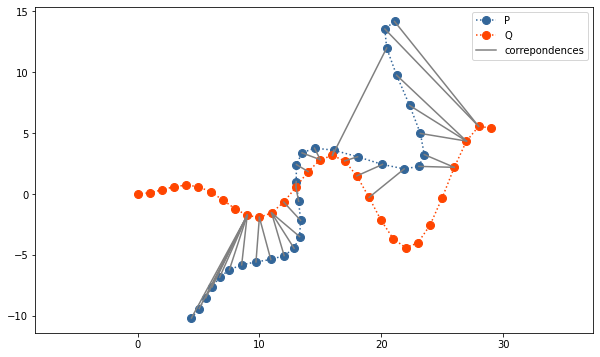

In [166]:


def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
      x = [P[0, i], Q[0, j]]
      y = [P[1, i], Q[1, j]]
      if not label_added:
          ax.plot(x, y, color='grey', label='correpondences')
          label_added = True
      else:
        ax.plot(x, y, color='grey')
    ax.legend()


def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    correspondences=[]
    
    i=0
    while(i < len(P[0])):
      p=np.array([P[0][i],P[1][i]])
      q=np.array([Q[0][0],Q[1][0]])
      min_distance = [np.linalg.norm(p-q),0]
      j=1
      while(j < len(Q[0])):
        q=np.array([Q[0][j],Q[1][j]])
        distance = np.linalg.norm(p-q)
        if(distance<min_distance[0]):
          min_distance = [distance,j]
        j+=1
      correspondences.append((i, min_distance[1]))
      i+=1
    return correspondences

P=center_data(moved_data, true_data)

correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, label_1='P', label_2='Q')
draw_correspondeces(P, Q, correspondences,ax)

In [167]:

def compute_cross_covariance(P,Q, correspondences):
  cross_cov_matrix=np.array([[0.0,0.0],[0.0,0.0]])

  for i,j in correspondences:
    p=[P[0][i],P[1][i]]
    q=[Q[0][j],Q[1][j]]
    cross_cov_matrix[0][0] += (p[0] - P[0].mean()) * (q[0] - Q[0].mean())
    cross_cov_matrix[1][0] += (p[0] - P[0].mean()) * (q[1] - Q[1].mean())
    cross_cov_matrix[0][1] += (p[1] - P[1].mean()) * (q[0] - Q[0].mean())
    cross_cov_matrix[1][1] += (p[1] - P[1].mean()) * (q[1] - Q[1].mean())
  cross_cov_matrix=cross_cov_matrix

  return cross_cov_matrix

print(compute_cross_covariance(P,Q,correspondences))

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]


[[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
[1.38731645 6.44455857]


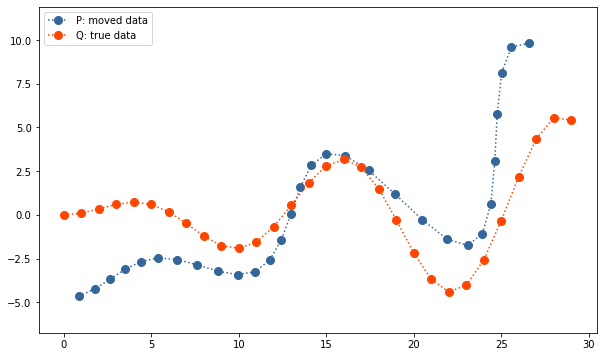

In [168]:
U,S,V = np.linalg.svd(compute_cross_covariance(P,Q,correspondences))
R = U.dot(V)
P_center = np.array([sum(P[0])/len(P[0]),sum(P[1])/len(P[1])])
Q_center = np.array([sum(Q[0])/len(Q[0]),sum(Q[1])/len(Q[1])])
t = Q_center - R.dot(P_center)
print(R)
print(t)

P = R.dot(P)
P[0] += t[0]
P[1] += t[1]


plot_data(P, Q, "P: moved data", "Q: true data")
plt.show()

[9576.632569787456, 257.6954152951461, 22.540574533875297, 0.3978374929972677, 5.217282378938214e-28, 8.698601050132359e-28, 9.839052022280927e-28, 1.1166610940386604e-27, 1.1366976988080874e-27, 1.2826454403657299e-27, 1.3623829845162445e-27]


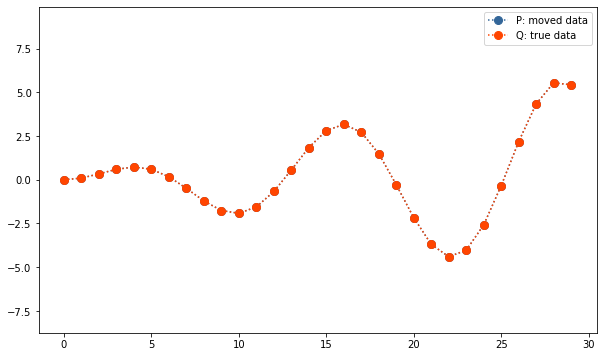

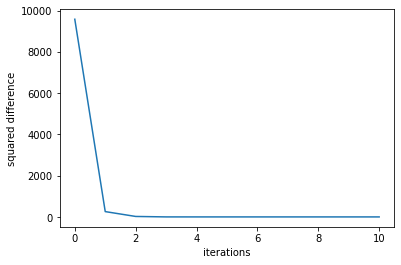

In [169]:
def icp_svd(P,Q):
  squared_differences = [np.sum((P-Q)**2)]
  for i in range(0,10):
    P = center_data(P,Q)
    correspondences = get_correspondence_indices(P,Q)
    cross_cov_matrix = compute_cross_covariance(P,Q,correspondences)
    U,S,V = np.linalg.svd(compute_cross_covariance(P,Q,correspondences))
    R = U.dot(V)
    P_center = np.array([sum(P[0])/len(P[0]),sum(P[1])/len(P[1])])
    Q_center = np.array([sum(Q[0])/len(Q[0]),sum(Q[1])/len(Q[1])])
    t = Q_center - R.dot(P_center)
    P = R.dot(P)
    P[0] += t[0]
    P[1] += t[1]
    squared_differences.append(np.sum((P-Q)**2))
  return P, Q, squared_differences 

Q = true_data
P = moved_data
P,Q, squared_differences = icp_svd(P,Q)

print(squared_differences)

plot_data(P, Q, "P: moved data", "Q: true data")
plt.show()
plt.plot(squared_differences)
plt.xlabel('iterations')
plt.ylabel('squared difference')
plt.show()
